<h1>Закономерности, опредлеяющие успешность игры. </h1>

**На основании данных из открытых источников за 2016 год (о продажах игр, оценки пользователей и экспертов, жанры и платформы, например, Xbox или PlayStation), мы вявим определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.**


# Оглавление

1. [Извлечение файлов и общий обзор данных](#1)
2. [Предобработка данных](#2)
3. [Предобработка данных: замена типов данных и наименований столбцов](#3)
4. [Исследовательский анализ данных](#4)
5. [Корреляция между рейтингом игры и прибылью](#5)
6. [Какие жанры самые прибыльные](#6)
7. [Портрет пользователя каждого региона](#7) 
- [Портрет игрока из стран Северной Америки](#8)
- [Портрет игрока из стран Евросоюза](#9)
- [Портрет игрока из Японии](#10)
9. [Проверка гипотез](#11)
10. [Общие выводы](#12)
    

<a id="1"></a>

<h2>Извление файлов и общий обзор данных</h2>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st # для гипотез
import numpy as np
import math as math
import matplotlib.ticker as ticker # для вспомогательной сетки и дополнеительных делений
import seaborn as sns

In [2]:
df = pd.read_csv('/datasets/games.csv')
df.head(5)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [4]:
df.describe()

,Year_of_Release,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score
count,16446.000000,16715.000000,16715.000000,16715.000000,16715.000000,8137.000000
mean,2006.484616,0.263377,0.145060,0.077617,0.047342,68.967679
std,5.877050,0.813604,0.503339,0.308853,0.186731,13.938165
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,71.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,79.000000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000


In [5]:
df.duplicated().sum()

0

In [6]:
for col in df.columns: # при помощи цикла отобразим пропуски в процентном соотношении
    pct_missed = np.mean(df[col].isnull()) # np.mean вычисляет долю числа пропусков в ячейке от общего числа значений в столбце
    print('{}: {} missed ({}%)'.format(col, df[col].isnull().sum(), round(pct_missed*100, 2)))

Name: 2 missed (0.01%)
Platform: 0 missed (0.0%)
Year_of_Release: 269 missed (1.61%)
Genre: 2 missed (0.01%)
NA_sales: 0 missed (0.0%)
EU_sales: 0 missed (0.0%)
JP_sales: 0 missed (0.0%)
Other_sales: 0 missed (0.0%)
Critic_Score: 8578 missed (51.32%)
User_Score: 6701 missed (40.09%)
Rating: 6766 missed (40.48%)


In [7]:
df.isnull().sum().sum() # сосчитаем общее количество пропусков.

22318

При первичном обзоре полученных данных мы видим, что отрицательных значений и странных числовых дипазонов не наблюдается. Однако, имеется множество пропусков, мы их отобразили в количественном выраженнии и процентном соотношении. В общей сумме необходимо обработать 22318 пропусков. Кроме того, названия столбцов необходимо привести к единому регистру, заменить типы данных. А также находим целесообразным посчитать суммарные продажи и записать их в отдельный столбец.


<a name="2"></a>

<h2>Предобработка данных: частичная обработка пропусков</h2>

В первую очередь, приведем названия столбцов к нижнему регистру.

In [8]:
df.columns = map(str.lower, df.columns) # приведение к нижнему регистру каждого названия столбца
df.head(1)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E


Перед тем как заменять типы данных, **необходимо принять решение о корректной замене пропусков**. К пропускам могло привести слияние с другими таблицами, либо недостаточное наличие данных изначально.<br>
Так как основной вопрос исследования касается успешности реализации и популярности игры, отраженном напрямую (в количестве проданных копий игры) сумме кассовых соборов, то **рейтинги игр несет второстепенное значение в исследовании**. Значение рейтинга игры, с одной стороны, является обосбленным независимым значением от рейтинга других игр, с другой - **рейтинг игры является относительно зависимым значением**: на оценку определнной игры оказывает влияние прошлый опыт игрока и текущий успех других игр, исходя из чего игрок оценивает текущую игру. <br>
    При визульном изучении таблицы, мы обнаружили взаимосвязь между отсутсвующими значениями в трёх слобцах (рейтинги критиков, игроков и возрастная категория): в подавляющем большинстве случаев, значения отсутвуют во всех трех колонках сразу. <br>
- **рейтинг критиков** - (достигает 51%) - по возможности, частично восстановим значения при помощи расчета значения на основе рейтинга игроков в соседнем столбце, так как рейтинги практичекски всегда коррелируют. Пропуски в которых неудасться произвести замену - оставим пропуски.
- **рейтинг игроков** (40%) - аналогично рассчитаем значение на основе соседнего столбца в обратную сторону. Пропуски в которых неудасться произвести замену - оставим пропуски.
- **классификации по возрасту** (40%) - заменим на строку "no age".
- **наименование игры** и **наименование жанра** - два наименования игры и два жанра пропущено (0,01%). Это одни и те же игры, кроме того в них отсутсвуют рейтинги и продажи минимальные - удалим эти 2 строки;
- **год выпуска** - 269 пропусков (2%) - подставим год выпуска игры. Это важно, так как необходимо будет определить последнию тенденцию в развитии игр. Оставшиеся 6 игр (0,03%), у которых неудастся произвести замену - удалим эти строки полностью, так как в них тоже мало информации, ни года выпуска, ни рейтингов, продажи нулевые.

Таким образом данные удасться восстановить у 900 игр.

**Заменим пропуски в разделе год выпуска реальными значениями из открытых источников.**

In [9]:
games = {'Madden NFL 2004': 2003, 'FIFA Soccer 2004': 2003, 'LEGO Batman: The Videogame': 2008, 'wwe Smackdown vs. Raw 2006': 2005,
         'Space Invaders': 1978, 'Rock Band': 2007, "Frogger's Adventures: Temple of the Frog": 2001, "Record of Agarest War Zero": 2009, 
         'LEGO Indiana Jones: The Original Adventures': 2008, "Charm Girls Club: My Fashion Mall": 2009, "Combat Elite: WWII Paratroopers": 2005, 
         'Call of Duty 3': 2006, 'Call of Duty: Black Ops': 2010, 'Triple Play 99': 1998, 'Adventure': 1979, 'Combat': 1977, 
         'LEGO Harry Potter: Years 5-7': 2011, 'NASCAR Thunder 2003': 2002, 'Hitman 2: Silent Assassin': 2002, 
         'Legacy of Kain: Soul Reaver': 1999, 'Donkey Kong Land III': 1997, 'Air-Sea Battle': 1977, 'Suikoden III': 2002, 
         'Wheel of Fortune': 2010, 'Yakuza 4': 2010, 'Namco Museum': 1995, 'Rhythm Heaven': 2008, "Charm Girls Club: My Fashion Mall": 2009,
         'The Lord of the Rings: War in the North': 2011, "Madden NFL 07": 2006, "MLB SlugFest 20-03": 2002, 
         'Shaun White Snowboarding': 2008, 'PES 2009: Pro Evolution Soccer': 2008, "WarioWare: Twisted!": 2004, "Rocksmith": 2011, 
         "Madden NFL 11": 2010, "Test Drive Unlimited 2": 2011, "The Chronicles of Narnia: The Lion, The Witch ...": 2005, 
         "Monster Hunter 2": 2006, "Metal Gear Solid 2: Substance": 2001, "Advance Wars: Days of Ruin": 2008, "The Golden Compass": 2007, 
         "Madden NFL 06": 2005, "NASCAR: Dirt to Daytona": 2002, "Madden NFL 2002": 2001, "Def Jam: Fight for NY": 2004, 
         "NBA Street Vol. 2": 2003, "Fishing Derby": 1980, "Wet": 2009, "Sonic the Hedgehog": 1991, "Karate": 1982, 
         "Tiger Woods PGA Tour 07": 2006, "Circus Atari": 1977, "The Chronicles of Riddick: Escape from Butcher Bay": 2004, 
         "Maze Craze: A Game of Cops 'n Robbers": 1978, "Silent Hill: Homecoming": 2008, "Hangman": 1978, "NBA Live 2003": 2002, 
         "Cubix Robots for Everyone: Clash 'n' Bash": 2002, "Dragon Ball Z: Budokai Tenkaichi 2 (JP sales)": 2005, "Tropico 4": 2011,
         "Tomb Raider (2013)": 2013, "Bejeweled 3": 2010, "Custom Robo": 1999, "Final Fantasy XI": 2002, "Singularity": 2010, 
         "Dragster": 1980, "All-Star Baseball 2005": 2004, "Star Wars Jedi Knight II: Jedi Outcast": 2002, "Slot Machine": 1979, 
         "The Dukes of Hazzard II: Daisy Dukes It Out": 2000, "Harvest Moon: The Tale of Two Towns": 2010, "NBA Live 2003": 2002, 
         "Shrek the Third": 2007, "Nicktoons: Battle for Volcano Island": 2006, "Haven: Call of the King": 2002, "Street Hoops": 2002, 
         "Unreal Championship 2: The Liandri Conflict": 2005, "Pac-Man Fever": 2002, "The Legend of Zelda: The Minish Cap": 2004, 
         "Indy 500": 1995, "Disgaea 3: Absence of Detention": 2008, "Flag Capture": 1978, "Gun": 2005, "Rock Revolution": 2008, 
         "College Hoops 2K6": 2005, "Jonah Lomu Rugby Challenge": 1977, "Mega Man X Collection": 2006, "BioShock 2": 2010, 
         "Danganronpa: Trigger Happy Havoc": 2010, "Jet X20": 2002, "Tony Hawk's Downhill Jam": 2006, "Tribes: Aerial Assault": 2002, 
         "Big Beach Sports 2": 2008, "Yu Yu Hakusho: Dark Tournament": 2004, "Ghostbusters II": 1990, "Breakaway IV": 1978, 
         "Robotech: Battlecry": 2002, "Move Fitness": 2013, "Valkyria Chronicles III: Unrecorded Chronicles": 2011, 
         "DanceDanceRevolution II": 2011, "WRC: FIA World Rally Championship": 2013, "Famista 64": 1997, "Dead Space 3": 2013, 
         "Pet Zombies": 2011, "Star Trek: Legacy": 2006, "Backbreaker": 2010, "Twisted Metal: Small Brawl": 2001, 
         "Otomedius Excellent": 2011, "NBA Starting Five": 2002, "Teen Titans": 2005, "Trauma Team": 2010, "GiFTPiA": 2003, 
         "James Cameron's Dark Angel": 2002, "Sword of the Samurai": 1989, "Splatterhouse": 1988, "Saru! Get You! Million Monkeys": 2006,  
         "Alone in the Dark: The New Nightmare": 2001, "Vegas Party": 2009, "Jurassic Park: The Game": 2011, "Home Run": 1978,
         "eJay Clubworld": 1978, "All-Star Baseball 2005": 2004, "Our House Party!": 2009, "WCW Backstage Assault": 2000,
         "Disney's Cinderella: Magical Dreams": 2005, "Transworld Surf": 2001, "Street Fighter IV": 2008, "Star Trek: Conquest": 2007, 
         "Nintendo Puzzle Collection": 2003, "Super Robot Wars OG Saga: Masou Kishin II": 2012, "The Daring Game for Girls": 2009, 
         "Godzilla: Destroy All Monsters Melee": 2002, "Major League Baseball 2K6": 2006, " Happy Feet Two": 2011, 
         "Disney's Chicken Little: Ace In Action": 2006, "Atsumare! Power Pro Kun no DS Koushien": 1999, "Demon Chaos": 2005,
         "My Healthy Cooking Coach": 2007, "Luminous Arc 2 (JP sales)": 2008, "Egg Monster Hero": 2005, "The Hidden": 2011, 
         "Samurai Shodown Anthology": 2008, "Action Man-Operation Extreme": 2000, "Super Puzzle Fighter II": 1996, "GRID": 2008, 
         "Charm Girls Club: My Fashion Show": 2009, "Face Racers: Photo Finish": 2011, "Zero: Tsukihami no Kamen": 2008, 
         "Get Fit with Mel B": 2011, "Mega Man Battle Network: Operation Shooting Star": 2009, "Smashing Drive": 2000, 
         "Port Royale 3": 2012, "Dream Trigger 3D": 2011, "Dead Island: Riptide": 2013, "Yoostar on MTV": 2011, "Tornado": 2008, 
         "McFarlane's Evil Prophecy": 2004, "Drake of the 99 Dragons": 2003, "Build-A-Bear Workshop: Friendship Valley": 2010,
         "Rayman Arena": 2001, "National Geographic Challenge!": 2011, "Alex Rider: Stormbreaker": 2006, "Chou Soujuu Mecha MG": 2006,
         "Prinny: Can I Really Be The Hero? (US sales)": 2008, "Flip's Twisted World": 2010, "Mobile Ops: The One Year War": 2008, 
         "Tom Clancy's Rainbow Six: Critical Hour": 2006, "Jewel Link Chronicles: Mountains of Madness": 2012, "Tube Slider": 2003, 
         "Captain America: Super Soldier": 2011, "Mountain Bike Adrenaline": 2008, "Drill Dozer": 2005, "Tour de France 2011": 2011, 
        "Reader Rabbit 2nd Grade": 1994, "Monster Hunter Frontier Online": 2007, "RollerCoaster Tycoon": 1999, "Battle vs. Chess": 2011,
         "The History Channel: Great Battles - Medieval": 2010, "Clockwork Empires": 2016, "B.L.U.E.: Legend of Water": 1998,
         "NHL Hitz Pro": 2003, "Luxor: Pharaoh's Challenge": 2008, "Sega Rally 2006": 2006, "Half-Minute Hero 2": 2011, 
         "Housekeeping": 2006, "Major League Baseball 2K8": 2008, "Sabre Wulf": 2004, "Swords": 2010, "Beyond the Labyrinth": 2012,
         "Bikkuriman Daijiten": 2007, "Majesty 2: The Fantasy Kingdom Sim": 2009, "Fullmetal Alchemist: Brotherhood": 2009, 
         "Samurai Spirits: Tenkaichi Kenkakuden": 2005, "World of Tanks": 2010, "Tom and Jerry in War of the Whiskers": 2002, 
         "Umineko no Naku Koro ni San: Shinjitsu to": 2007, "Payout Poker & Casino": 2006, "Wii de Asobu: Metroid Prime": 2009, 
         "Legacy of Ys: Books I & II": 2009, "Saint": 2009, "Steal Princess": 2008, "Mario Tennis": 2012, "Runaway: A Twist of Fate": 2009, 
         "Super Duper Sumos": 2003, "The King of Fighters: Maximum Impact - Maniax": 2004, "Combat Wings: The Great Battles of WWII": 2012,
         "Yu-Gi-Oh! 5D's Wheelie Breakers (JP sales)": 2009, "Cabela's Alaskan Adventure": 2006, "Virtua Quest": 2004, 
         "Shonen Jump's Yu-Gi-Oh! GX Card Almanac": 2007, "Without Warning": 2005, "PDC World Championship Darts 2008": 2008, 
         "Dinotopia: The Sunstone Odyssey": 2003, "Jet Impulse": 2007, "Dream Dancer": 2009, "Dance! It's Your Stage": 2010, 
         "Football Manager 2007": 2006, "Ferrari: The Race Experience": 2010, "Aquaman: Battle for Atlantis": 2003, 
         "Homeworld Remastered Collection": 2015, "Shorts": 2009, "AKB1/48: Idol to Guam de Koishitara": 2010, 
         "Brothers in Arms: Furious 4": 2015, "Agarest Senki: Re-appearance": 2007, "PDC World Championship Darts 2008": 2008,
         "Freaky Flyers": 2003, "Inversion": 2012, "Hakuouki: Shinsengumi Kitan": 2010, "Happy Feet Two": 2011, "TERA": 2011, 
        "Robert Ludlum's The Bourne Conspiracy": 2008, "Super Breakout": 1976, "NHL Slapshot": 2010, "NFL GameDay 2003": 2002,
         "Harvest Moon: Save the Homeland": 2001, "Writing and Speaking Beautiful Japanese DS": 2008, }

def put_year_in(row):
    s = str(row['year_of_release'])    # определим есть ли в строке nan и преобразуем для возможности сравнения в строку
    if s != 'nan':                  # если в строке не nan
        return row['year_of_release']  # то мы вернем прежнее значение в ячейку
    if row['name'] in games and s == 'nan': # если город есть в словаре и строка == nan
        return games[row['name']]           # в таблице nan меняем на найденное значение года выпуска в словаре
    else:
        return row['year_of_release']

df['year_of_release'] = df.apply(put_year_in, axis=1)

number = df.year_of_release.isnull().sum()
print(f'В {number} играх не удалось подставить год выпуска игры')

В 6 играх не удалось подставить год выпуска игры


Игры, в которых не удалось подставить год выпуска, предлагаю позже удалить, так как в них мало информации: ни года выпуска, ни рейтингов, продажи нулевые.

Разберемся отдельно со значениями **tbd** в **user_score**.

In [10]:
df[df['user_score'] == 'tbd'].head(5)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
119,Zumba Fitness,Wii,2010.0,Sports,3.45,2.59,0.0,0.66,NaN,tbd,E
301,Namco Museum: 50th Anniversary,PS2,2005.0,Misc,2.08,1.35,0.0,0.54,61.0,tbd,E10+
520,Zumba Fitness 2,Wii,2011.0,Sports,1.51,1.03,0.0,0.27,NaN,tbd,T
645,uDraw Studio,Wii,2010.0,Misc,1.65,0.57,0.0,0.20,71.0,tbd,E
657,Frogger's Adventures: Temple of the Frog,GBA,2001.0,Adventure,2.15,0.18,0.0,0.07,73.0,tbd,E


Аббревиатура **tbd** (*to be determined*) - значение должно быть определено, в столбце **user_score** встречается 2424 раза (14,5%), видимо, ожидалась оценка игроков.

 Значение **tbd** предлагаем рассматривать как отсутсвующие значение **NaN** и заменить его на основе рейтинга критиков, так как значение коррелируют. При помощи объявленной ниже функции и метода .apply() нам удасться восстановить 1100 значений вместо tbd. 

**Заменим значения tbd на коррелирующее значение из рейтинга критиков.**

In [11]:
def from_critic_to_users(row): 
    s = str(row['user_score'])      # преобразовываем значение user_score в строку
    critic_s = str(row['critic_score']) # записываем строку в переменную
    if s == 'tbd' and critic_s != 'nan': # Tесли рейтинг игрока равен tbd и соседний рейтинг критика не 'nan'
        return round(row['critic_score'] / 10, 1) # записываем в users_score рейтинг критиков поделенный на 10. 
    else: 
        return row['user_score'] # в противном случае: ничего не получилось - возвращаем значение на место как было

df['user_score'] = df.apply(from_critic_to_users, axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
name               16713 non-null object
platform           16715 non-null object
year_of_release    16709 non-null float64
genre              16713 non-null object
na_sales           16715 non-null float64
eu_sales           16715 non-null float64
jp_sales           16715 non-null float64
other_sales        16715 non-null float64
critic_score       8137 non-null float64
user_score         10014 non-null object
rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [12]:
len(df[df['user_score'] == 'tbd']) # считаем сколько у нас осталось tbd

1342

Отслось 1342 tbd, которые рассчитать на основе данных стаолбца critic_score не удается. **Оставшиеся значения tbd заменим на nan**, чтобы затем успешно поменять тип данных.

In [13]:
df['user_score'] = df['user_score'].replace('tbd', np.nan)
number = len(df[df['user_score'] == 'tbd'])
print(f'осталось {number} значений tbd.')

осталось 0 значений tbd.


**Избавимся от пустых значений в user_score** на основе данных **critic_score**, так как столбцы визуально коррелируют, что даст всего лишь **+38 значений**, так как отсутсвуют значения одновременно в обоих колонках. **Оставшиеся пропуски оставим как есть (был вариант заменить на ноль)**

In [14]:
df.loc[df.user_score.isnull(), 'user_score'] = round(df.critic_score / 10, 1) # +38 non-null
# df.loc[df.user_score.isnull(), 'user_score'] = "0" # вставим 0 в 6663 пропуска, где не удалось произвести замену на основе соседнего столбца
# df.loc[df.critic_score.isnull(), 'critic_score'] = "0" # вставим 0 в 8578 позиций пропуска critic_score
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
name               16713 non-null object
platform           16715 non-null object
year_of_release    16709 non-null float64
genre              16713 non-null object
na_sales           16715 non-null float64
eu_sales           16715 non-null float64
jp_sales           16715 non-null float64
other_sales        16715 non-null float64
critic_score       8137 non-null float64
user_score         8710 non-null object
rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


**Пропуски значений в позиции возрастной категории, заменим на no age.**

In [15]:
df.loc[df.rating.isnull(), 'rating'] = "no age"

Посмотрим на те самые 2 игры с отсуствующими названиями игр и жанров, убедимся, что в них нет ценной инфоромации, так как практически полностью отсуствую данные и по другим параметрам.

Игры с отсутсвующими **2 названиями и жанров и рейтингов - удалим**.

In [16]:
df[df.name.isnull()].tail(20) # показать что в этих двух строках ничего ценного нет, можно удалять.

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,no age
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,no age


In [17]:
df.drop(df[df.name.isnull()].index, inplace=True)
print(f'Осталось {df.name.isnull().sum()} пустых значений. 2 неинформативные игры удалены.')

Осталось 0 пустых значений. 2 неинформативные игры удалены.


In [18]:
df[df.year_of_release.isnull()].tail(20)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
3024,"The Chronicles of Narnia: The Lion, The Witch ...",GBA,NaN,Action,0.48,0.18,0.00,0.01,66.0,6.8,E
6180,"The Chronicles of Narnia: The Lion, The Witch ...",GC,NaN,Action,0.22,0.06,0.00,0.01,71.0,7.1,T
6255,The Legend of Zelda: The Minish Cap(weekly JP ...,GBA,NaN,Action,0.00,0.00,0.27,0.01,NaN,NaN,no age
9738,Super Robot Wars OG Saga: Masou Kishin II - Re...,PSP,NaN,Strategy,0.00,0.00,0.12,0.00,NaN,NaN,no age
15022,Umineko no Naku Koro ni San: Shinjitsu to Gens...,PS3,NaN,Adventure,0.00,0.00,0.02,0.00,NaN,NaN,no age
16293,AKB1/48: Idol to Guam de Koishitara...,X360,NaN,Misc,0.00,0.00,0.01,0.00,NaN,NaN,no age


In [19]:
df.drop(df[df.year_of_release.isnull()].index, inplace=True) # удалим игры сотсутсвующим годом и и посчитаем пропуски как 
df.year_of_release.isnull().sum()                            # доказательство, что игры удалены

0

Таким образом, вто втором разделе мы избавились от 22318 пропусков.

<a name="3"></a>

<h2>Предобработка данных: замена типов данных и наименований столбцов</h2>

В наборе данных попадается аббревиатура **ESRB** (*Entertainment Software Rating Board*) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков». В таблице данные о ранжировании по возрасту содержатся в столбце **raiting**, для устранения двусмысленности, данный столбец необходимо будет переименовать в название, отражающее возрастную катеогорию - **age**.

Переименуенм столбец raiting в age.

In [20]:
df.rename(columns = {'rating':'age'}, inplace = True)
df.head(1)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,age
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E


**Заменим типы данных:** 
* **year_of_release** - год не может быть дробным числом - заменим на целочисленный тип int64; 
* **user_score** - рейтинг пользователей должен быть дробным числом, а не строкой - заменим на дробный тип данных float64;
* **critic_score** - рейтинг пользователей должен быть дробным числом, а не строкой - заменим на дробный тип данных float64.

In [21]:
df = df.astype({'year_of_release': 'int',
           'user_score': 'float',
          'critic_score': 'float'})

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16707 entries, 0 to 16714
Data columns (total 11 columns):
name               16707 non-null object
platform           16707 non-null object
year_of_release    16707 non-null int64
genre              16707 non-null object
na_sales           16707 non-null float64
eu_sales           16707 non-null float64
jp_sales           16707 non-null float64
other_sales        16707 non-null float64
critic_score       8135 non-null float64
user_score         8708 non-null float64
age                16707 non-null object
dtypes: float64(6), int64(1), object(4)
memory usage: 1.5+ MB


А также находим целесообразным **посчитать суммарные продажи** и записать их в отдельный столбец, так кассовые сборы являютсмя основным показателем успешности игры для разработчиков и маркетологов.

In [23]:
df['total_profit'] = df.na_sales + df.eu_sales + df.jp_sales + df.other_sales
df.head(5)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,age,total_profit
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,no age,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,no age,31.38


<a name="4"></a>

<h2>Исследовательский анализ данных</h2>

Посмотрим, сколько игр выпускалось в разные годы. Важны ли данные за все периоды?


In [24]:
# by_years = df.pivot_table(index='year_of_release', values='', aggfunc=['sum', 'count'])
by_years = df.groupby('year_of_release').sum()
by_years['counter_games'] = df.pivot_table(index='year_of_release', values='name', aggfunc='count') # посчитать игры по годам и приклеить к нижней таблице колво игр
by_years

,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,total_profit,counter_games
year_of_release,,,,,,,,
1976,0.41,0.03,0.00,0.00,0.0,0.0,0.44,1
1977,2.51,0.35,0.00,0.08,64.0,6.4,2.94,4
1978,3.79,0.28,0.00,0.05,69.0,8.6,4.12,7
1979,1.50,0.10,0.00,0.01,0.0,0.0,1.61,2
1980,11.37,0.72,0.00,0.13,0.0,0.0,12.22,11
1981,33.40,1.96,0.00,0.32,0.0,0.0,35.68,46
1982,27.36,1.68,0.00,0.31,0.0,0.0,29.35,37
1983,7.76,0.80,8.10,0.14,0.0,0.0,16.80,17
1984,33.28,2.10,14.27,0.70,0.0,0.0,50.35,14


Уйстойчивой тенденции к росту прибыли до 1994 года не наблюдалось. **Рейтинги игроков стабильно начали учитывать с 1996 года**, до этого, оценки мнений игроков и исследователей не систематизировались. **Бурное развитие игровой индустрии наблюдается с 1994 по 2007 год**, после чего идет умеренный спад. **С 2007 по 2009 года в течение трех лет наблюдается перенасыщение рынка**, однако возникший мировой кризис 2008 года поспособствует снижению выручки, и **при сохраняющихся темпах производства новых игр, 2008 и 2009 год будут приносить меньше прибыли**, что затем вызовет  постепенное снижение объемов выпуска новых игр вплоть до 2010 года. 2010 год ознаменован распространением смартфонов, что также заберет часть рынка игр на себя. **После совокупности данных событий, объемы производства игр сохранятся на уровне 2012 года при продолжении снижения выручки, что говорит о продолжающимся перенасыщении рынка**, либо о предпочтении игроков к более старым форматам игр, либо отсутсвию оригинальных идей у разработчиков, либо отсутствие учета предпочтений игроков при разработке, либо успехом такой новинки как смартфон.

Таким образом **период с 1994 года по 2008 год можно считать самым успешным** в производстве игр, а **с 2012 года формируется новый рынок** с усточивым объемом производства игр.

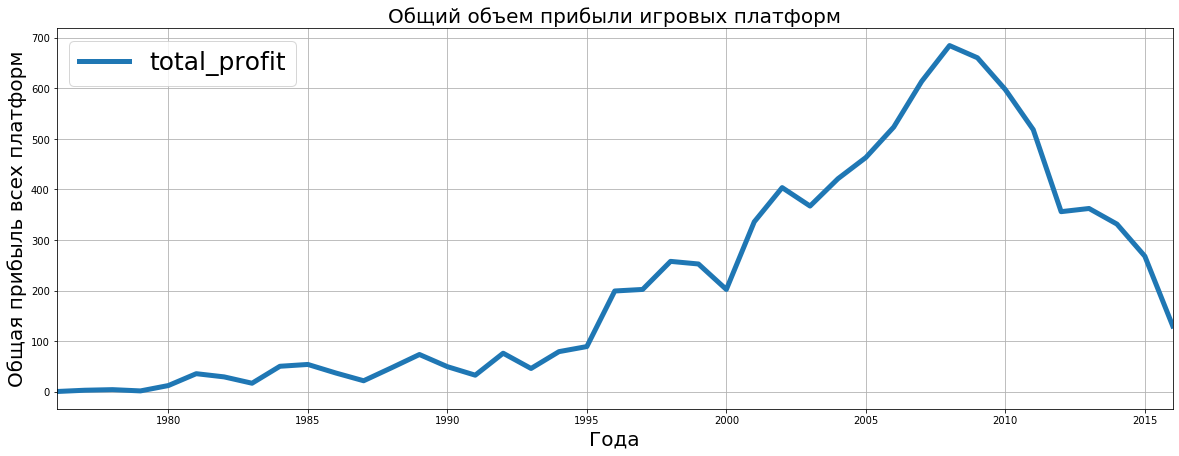

In [25]:
profit = by_years['total_profit']
games = by_years['counter_games'].astype('float')

profit.plot(figsize=(20, 7), grid=True, linewidth=5)
# games.plot(figsize=(20, 7), grid=True, linewidth=5)

plt.legend(loc=2, prop={'size': 25})
plt.xlabel('Года', fontsize=20)
plt.ylabel('Общая прибыль всех платформ', fontsize=20)
plt.title('Общий объем прибыли игровых платформ', fontsize=20)
plt.show()

Изучим изменения продаж по игровым платформам. Выберем платформы с наибольшими суммарными продажами и построим распределение по годам. Определеим, за какой характерный срок появляются новые и исчезают старые платформы.

In [26]:
by_platforms = df.groupby('platform').sum()
by_platforms['counter_games_by_platforms'] = df.pivot_table(index='platform', values='name', aggfunc='count') # посчитать игры по годам и приклеить к нижней таблице колво игр

top_10_platforms = by_platforms.sort_values(by='total_profit', ascending=False).head(10)
top_10_platforms = top_10_platforms[['total_profit', 'counter_games_by_platforms', 'na_sales', 'eu_sales', 'jp_sales', 'other_sales', 'critic_score', 'user_score']]
top_10_platforms

,total_profit,counter_games_by_platforms,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score
platform,,,,,,,,
PS2,1255.77,2161,583.84,339.29,139.20,193.44,89208.0,10315.3
X360,971.41,1261,602.47,270.76,12.42,85.76,62853.0,6659.6
PS3,939.63,1330,393.49,330.29,80.17,135.68,57714.0,6076.0
Wii,907.51,1320,496.90,262.21,69.33,79.07,36752.0,4287.0
DS,806.12,2151,382.40,188.89,175.57,59.26,45717.0,5074.7
PS,730.86,1197,336.52,213.61,139.82,40.91,14303.0,1548.1
GBA,316.90,820,187.06,75.07,47.06,7.71,29443.0,3202.7
PS4,314.14,392,108.74,141.09,15.96,48.35,18167.0,1754.9
PSP,293.93,1208,109.17,66.68,76.66,41.42,31150.0,3457.1


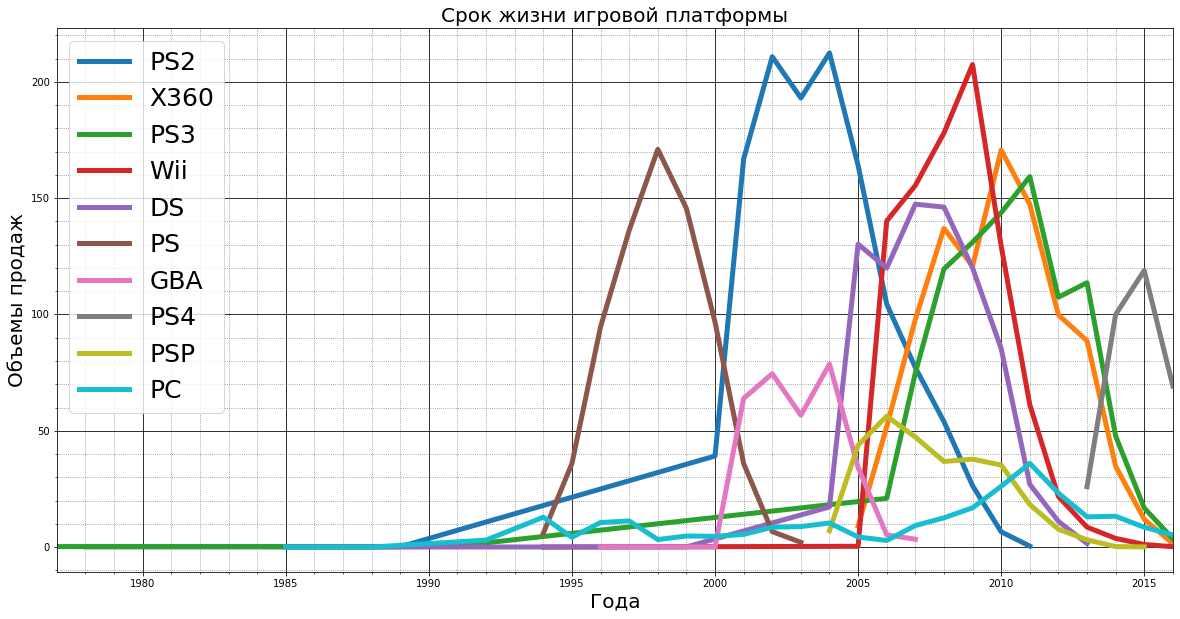

In [27]:
# для каждой линии графика сформируем series по определнной платформе. Полученную таблицу сгруппируем по году выхода игры на 
# данной платформе и ссумируем продажи на этой платформе за каждый год (объхем продаж за каждый год на даннйо платформе)
# series преобразуем в dataframe? чтобы линия отображалась на графике
# столбец с суммами прибыли переименуем в название платформы, чтобы подпись к линии на графике соответсовала названию платформы
# проделаем олинаковые дейсвтия для каждой платформы
PS2_by_year = df[df['platform'] == 'PS2'].groupby(['year_of_release'])['total_profit'].agg('sum')
PS2_by_year = pd.DataFrame(PS2_by_year)
PS2_by_year = PS2_by_year.rename(columns={'total_profit': 'PS2'})

X360_by_year = df[df['platform'] == 'X360'].groupby(['year_of_release'])['total_profit'].agg('sum')
X360_by_year = pd.DataFrame(X360_by_year)
X360_by_year = X360_by_year.rename(columns={'total_profit': 'X360'})

PS3_by_year = df[df['platform'] == 'PS3'].groupby(['year_of_release'])['total_profit'].agg('sum')
PS3_by_year = pd.DataFrame(PS3_by_year)
PS3_by_year = PS3_by_year.rename(columns={'total_profit': 'PS3'})

Wii_by_year = df[df['platform'] == 'Wii'].groupby(['year_of_release'])['total_profit'].agg('sum')
Wii_by_year = pd.DataFrame(Wii_by_year)
Wii_by_year = Wii_by_year.rename(columns={'total_profit': 'Wii'})

DS_by_year = df[df['platform'] == 'DS'].groupby(['year_of_release'])['total_profit'].agg('sum')
DS_by_year = pd.DataFrame(DS_by_year)
DS_by_year = DS_by_year.rename(columns={'total_profit': 'DS'})

PS_by_year = df[df['platform'] == 'PS'].groupby(['year_of_release'])['total_profit'].agg('sum')
PS_by_year = pd.DataFrame(PS_by_year)
PS_by_year = PS_by_year.rename(columns={'total_profit': 'PS'})

GBA_by_year = df[df['platform'] == 'GBA'].groupby(['year_of_release'])['total_profit'].agg('sum')
GBA_by_year = pd.DataFrame(GBA_by_year)
GBA_by_year = GBA_by_year.rename(columns={'total_profit': 'GBA'})

PS4_by_year = df[df['platform'] == 'PS4'].groupby(['year_of_release'])['total_profit'].agg('sum')
PS4_by_year = pd.DataFrame(PS4_by_year)
PS4_by_year = PS4_by_year.rename(columns={'total_profit': 'PS4'})

PSP_by_year = df[df['platform'] == 'PSP'].groupby(['year_of_release'])['total_profit'].agg('sum')
PSP_by_year = pd.DataFrame(PSP_by_year)
PSP_by_year = PSP_by_year.rename(columns={'total_profit': 'PSP'})

PC_by_year = df[df['platform'] == 'PC'].groupby(['year_of_release'])['total_profit'].agg('sum')
PC_by_year = pd.DataFrame(PC_by_year)
PC_by_year = PC_by_year.rename(columns={'total_profit': 'PC'})


# создадим списко платформ, чтобы итерировать его циклом
scenarios = [PS2_by_year, X360_by_year, PS3_by_year, Wii_by_year, DS_by_year, PS_by_year, GBA_by_year, PS4_by_year, 
             PSP_by_year, PC_by_year]
fig, ax = plt.subplots()


for m in scenarios:
    m.plot(ax=ax, figsize=(20, 10), grid=True, linewidth=5)

    #  Устанавливаем интервал основных и вспомогательных делений:
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(50))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(10))


#  Добавляем линии основной сетки:
ax.grid(which='major',
        color = 'k')

#  Включаем видимость вспомогательных делений:
ax.minorticks_on()
#  Теперь можем отдельно задавать внешний вид вспомогательной сетки:
ax.grid(which='minor',
        color = 'gray',
        linestyle = ':')

plt.legend(loc=2, prop={'size': 25}) #  устновить размер легенды и ее положение (2 - верхний левый угол)
plt.ylabel('Объемы продаж', fontsize=20)
plt.xlabel('Года', fontsize=20)
plt.title('Срок жизни игровой платформы', fontsize=20)

plt.show()


На полученном графике, мы видим, что средний жизненный цикл игровой платформы составляет 5-10 лет. 
Лидерами по побъем выпущенных игр, для этих приставок являлись PS2, X360, Wii, PS3.
На данный момент, все из них находятся в упадке по объемам выпускаемых игр для этих платформ, что объясняется развитием онлайн игр и смартфонов, которые заменяют приставки.
Сравнительно большее количество игр на конец исследуемого периода выпускается для PS4, PS3, X360 и PC.

После 2012 года на всем рынке игровых платформ наступил негативный период, который характеризуется небольшими объемами продаж. С началом развития совеременных смартфонов - ознаменован новый период развития. Возьмём данные за соответствующий актуальный период с 2012 года. Основной фактор — эти данные помогут построить прогноз на 2017 год.

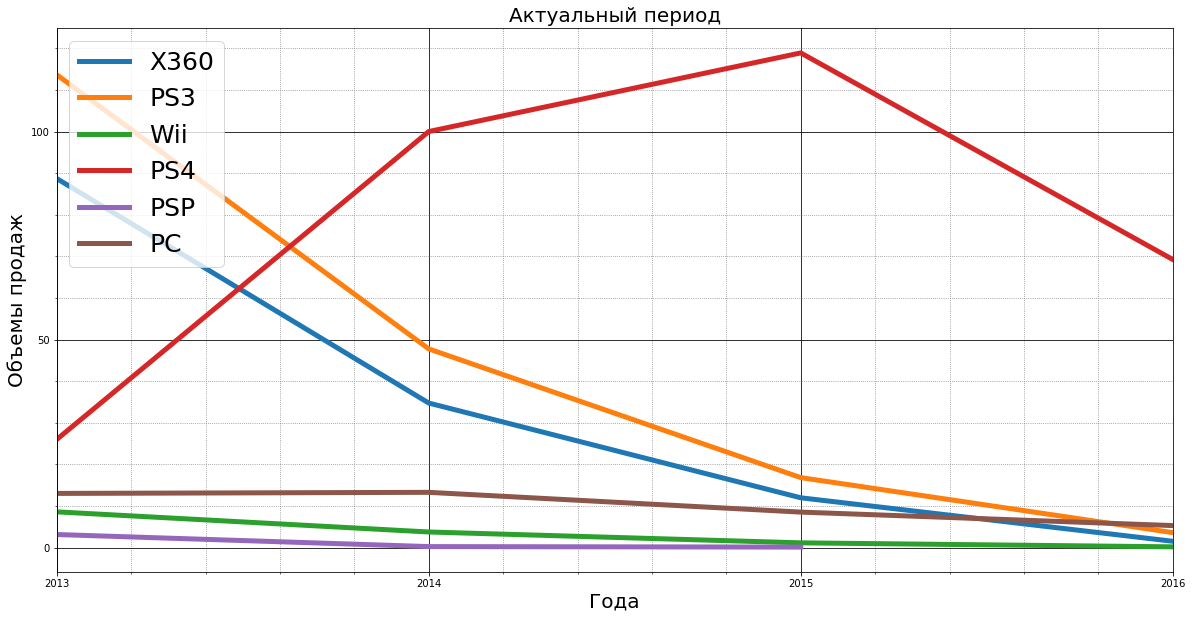

In [28]:
#PS2_by_year = PS2_by_year.reset_index()
#PS2_by_year = PS2_by_year[PS2_by_year['year_of_release'] >= 2010]
#PS2_by_year = PS2_by_year.set_index('year_of_release')

X360_by_year = X360_by_year.reset_index()
X360_by_year = X360_by_year[X360_by_year['year_of_release'] > 2012]
X360_by_year = X360_by_year.set_index('year_of_release')

PS3_by_year = PS3_by_year.reset_index()
PS3_by_year = PS3_by_year[PS3_by_year['year_of_release'] > 2012]
PS3_by_year = PS3_by_year.set_index('year_of_release')

Wii_by_year = Wii_by_year.reset_index()
Wii_by_year = Wii_by_year[Wii_by_year['year_of_release'] > 2012]
Wii_by_year = Wii_by_year.set_index('year_of_release')

DS_by_year = DS_by_year.reset_index()
DS_by_year = DS_by_year[DS_by_year['year_of_release'] > 2012]
DS_by_year = DS_by_year.set_index('year_of_release')

#PS_by_year = PS_by_year.reset_index()
#PS_by_year = PS_by_year[PS_by_year['year_of_release'] >= 2008]
#PS_by_year = PS_by_year.set_index('year_of_release')

#GBA_by_year = GBA_by_year.reset_index()
#GBA_by_year = GBA_by_year[GBA_by_year['year_of_release'] >= 2008]
#GBA_by_year = GBA_by_year.set_index('year_of_release')

PS4_by_year = PS4_by_year.reset_index()
PS4_by_year = PS4_by_year[PS4_by_year['year_of_release'] > 2012]
PS4_by_year = PS4_by_year.set_index('year_of_release')

PSP_by_year = PSP_by_year.reset_index()
PSP_by_year = PSP_by_year[PSP_by_year['year_of_release'] > 2012]
PSP_by_year = PSP_by_year.set_index('year_of_release')

PC_by_year = PC_by_year.reset_index()
PC_by_year = PC_by_year[PC_by_year['year_of_release'] > 2012]
PC_by_year = PC_by_year.set_index('year_of_release')


scenarios = [X360_by_year, PS3_by_year, Wii_by_year, PS4_by_year, PSP_by_year, PC_by_year]
fig, ax = plt.subplots()

for m in scenarios:
    m.plot(ax=ax, figsize=(20, 10), grid=True, linewidth=5,) #  marker='o', 
    
#  Устанавливаем интервал основных и вспомогательных делений:
ax.xaxis.set_major_locator(ticker.MultipleLocator(1)) # каждый 1
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(50))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(10))


#  Добавляем линии основной сетки:
ax.grid(which='major',
        color = 'k')

#  Включаем видимость вспомогательных делений:
ax.minorticks_on()
#  Теперь можем отдельно задавать внешний вид вспомогательной сетки:
ax.grid(which='minor',
        color = 'gray',
        linestyle = ':')

plt.legend(loc=2, prop={'size': 25}) #  устновить размер легенды и ее положение (2 - верхний левый угол)
plt.ylabel('Объемы продаж', fontsize=20)
plt.xlabel('Года', fontsize=20)
plt.title('Актуальный период', fontsize=20)

plt.show()


PS, DS, PS2 и GBA прекратили свое существоание после 2013 года. Продолжающют существовать из гигантов игрового рынка на конец 2015 года X360, PS3, PS4, PC, Wii - объемы производства игр на этих платформах продолжают снижаться.
Единственный фаворит игрового рынка, помимо мобильных устройств и компьютеров **остается единственный фаворит рынка - PS4**, однако его популярность также идет на снижение. Учитывая среднюю продолжительность жизни игровой платформы в 5-10 лет, **PS4 будет актуальна до 18-23 года**.

Построим график «ящик с усами» по глобальным продажам игр в разбивке по платформам.


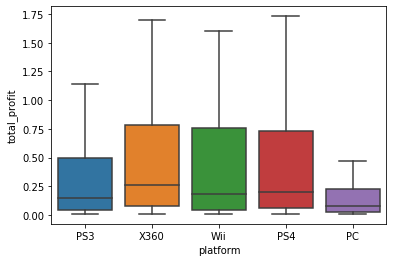

In [29]:
# Сформируем новый датафрейм, на основе выбора определенных платформ, иссумируем у них у них прибыль по годам. 
# К сформированному датафрейму по колонке будем добавлять в датафрейм колонки с прибылью следующей платформы.
ps3 = df[df['platform'] == 'PS3']
ps3 = ps3.query('year_of_release > 2012')

X360 = df[df['platform'] == 'X360']
X360 = X360.query('year_of_release > 2012')

Wii = df[df['platform'] == 'Wii']
Wii = Wii.query('year_of_release > 2012')

ps4 = df[df['platform'] == 'PS4']
ps4 = ps4.query('year_of_release > 2012')

pc = df[df['platform'] == 'PC']
pc = pc.query('year_of_release > 2012')

data = pd.concat([ps3, X360, Wii, ps4, pc])

sns.boxplot(x='platform', y='total_profit', data=data, showfliers=False)
plt.rcParams['figure.figsize']=(15,7)


plt.show()

Boxplot на полученном распределннии показывает сколько копий игр в среднем было продано за актуальные последние 4 года: самые популярные игры на X360 и PS4.

За всю историю наблюдения, для Х360 было выпущено 1261 игра за 11 лет существоания (в среднем 114 игр в год), а для PS4 было выпущено 392 игры за 3 года существования (в среднем 130 игр в год), при меньшем сроке существования PS4 почти в 4 раза, количество копий игр выпущено практически столько же сколько и для X360, что отображено на Boxplot, что еще раз подтверждает, что PS4 гораздо популярнее.  

Для PC было выпущено меньше всего копий игр. 

<a name="5"></a>

<h2>Корреляция между рейтингом игры и прибылью</h2>

Посмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Построим диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами. Для начала вспомним, какая платформа была ниболее популярной за историю, и составим выборку игры для этой плдатформы.

Ранее мы выяснили, что несмотря на то, что самой популярной на рынке игровых платформ за всю истрорию была платформа PS2, однако производство игр для этой платформы уже прекращено. **Текущим лидером на 2016 год остается платфрма PS4**.

In [30]:
PS4_platform = df[df['platform'] == 'PS4'] # Выберем игры, выпущенные для платформы PS4.
PS4_platform.loc[:, ['user_score', 'critic_score', 'total_profit']].corr()
# на корреляцию оказывает влияние что мы оставили пропуски как есть не стали их менять на что-либо

,user_score,critic_score,total_profit
user_score,1.000000,0.557390,-0.032459
critic_score,0.557390,1.000000,0.406568
total_profit,-0.032459,0.406568,1.000000


На платформе PS4 **корреляция между оценкой игроков и объемом прибыли нулевая** <br>
**Корреляция между оценкой профессиоанльных критиков и объемом прибыли значительная: 4 к 10.** <br>
слабую корреляцию между оценкой игроков и прибылью подтвердит график рассеяния ниже.

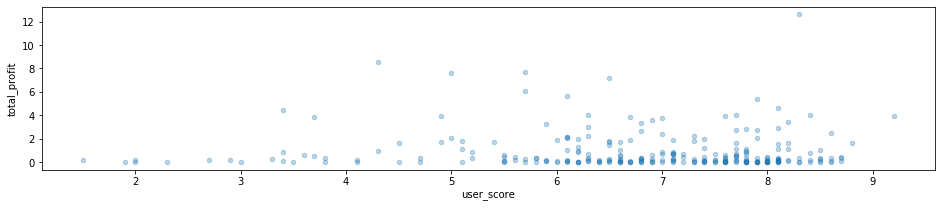

In [31]:
PS4_platform.plot(x='user_score', y='total_profit', kind='scatter', alpha=0.3, figsize=(16, 3))
plt.show()

Для игр, выпущенных для платформы PS4, положиетльные отзывы имеют незначительное влияние на продажи. Один и тот же размер прибыли могут приносить игры и с небольшим рейтингом и с высоким. Наблюдается достаточно слабая корреляция размера прибыли от рейтинга игры у пользователей.

Сравним корреляции на других платформах.

In [32]:
X360_platform = df[df['platform'] == 'X360'] # Выберем игры, выпущенные для платформы X360.
X360_platform.loc[:, ['user_score', 'critic_score', 'total_profit']].corr()

,user_score,critic_score,total_profit
user_score,1.000000,0.631494,0.121858
critic_score,0.631494,1.000000,0.393736
total_profit,0.121858,0.393736,1.000000


**На платформе X360 корреляция чуть выше.**<br>
**Между оценкой игроков и объемом прибыли существует весьма незначительная: 1 к 10.** <br>
**Между оценкой профессиоанльных критиков и объемом прибыли тоже незначительная, но чуть выше: 4 к 10.** <br>
слабую положительную корреляцию между оценкой игроков и прибылью подтвердит график рассеяния ниже.

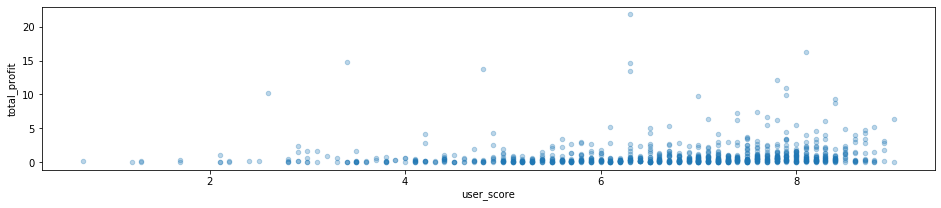

In [33]:
X360_platform.plot(x='user_score', y='total_profit', kind='scatter', alpha=0.3, figsize=(16, 3))
plt.show()

In [34]:
Wii_platform = df[df['platform'] == 'Wii'] # Выберем игры, выпущенные для платформы Wii.
Wii_platform.loc[:, ['user_score', 'critic_score', 'total_profit']].corr()

,user_score,critic_score,total_profit
user_score,1.000000,0.732934,0.126439
critic_score,0.732934,1.000000,0.177560
total_profit,0.126439,0.177560,1.000000


На платформе Wii корреляция слабже.<br>
**Между оценкой игроков и объемом прибыли существует весьма незначительная: 1 к 10.**<br>
**Между оценкой профессиоанльных критиков и объемом прибыли тоже незначительная, но чуть выше: 1 к 10.**<br>
слабую положительную корреляцию (практически нулевую) между оценкой игроков и прибылью подтвердит график рассеяния ниже.

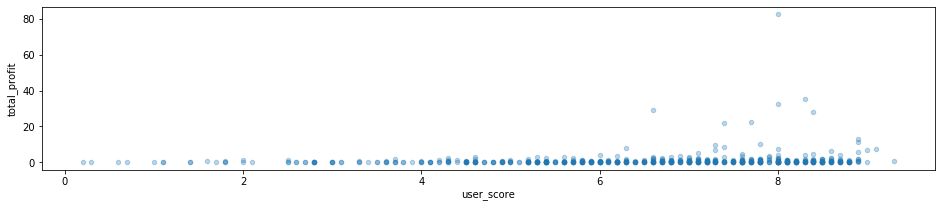

In [35]:
Wii_platform.plot(x='user_score', y='total_profit', kind='scatter', alpha=0.3, figsize=(16, 3))
plt.show()

In [36]:
PS3_platform = df[df['platform'] == 'PS3'] # Выберем игры, выпущенные для платформы PS3.
PS3_platform.loc[:, ['user_score', 'critic_score', 'total_profit']].corr()

,user_score,critic_score,total_profit
user_score,1.000000,0.643607,0.134703
critic_score,0.643607,1.000000,0.432432
total_profit,0.134703,0.432432,1.000000


**На платформе PS3 корреляция сильнее,** чем на остальных платформах.<br>
**Между оценкой игроков и объемом прибыли существует весьма незначительная: 0.1 к 10.**<br>
**Между оценкой профессиоанльных критиков и объемом прибыли тоже незначительная, но чуть выше: 4.3 к 10.**<br>
Положительную корреляцию между оценкой игроков и прибылью подтвердит график рассеяния ниже.

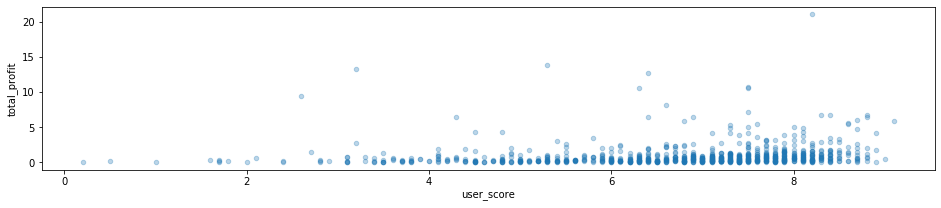

In [37]:
PS3_platform.plot(x='user_score', y='total_profit', kind='scatter', alpha=0.3, figsize=(16, 3))
plt.show()

In [38]:
PC_platform = df[df['platform'] == 'PC'] # Выберем игры, выпущенные для платформы PS3.
PC_platform.loc[:, ['user_score', 'critic_score', 'total_profit']].corr()

,user_score,critic_score,total_profit
user_score,1.000000,0.561709,0.013321
critic_score,0.561709,1.000000,0.256887
total_profit,0.013321,0.256887,1.000000


**На платформе PC корреляция нулевая** - самая слабая из всех платформ. <br>
**Между оценкой игроков и объемом прибыли существует весьма незначительная: 0 к 10.** <br>
**Между оценкой профессиоанльных критиков и объемом прибыли тоже незначительная, но чуть выше: 0.25 к 10.** <br>
Отсутствие между оценкой игроков и прибылью подтвердит график рассеяния ниже.

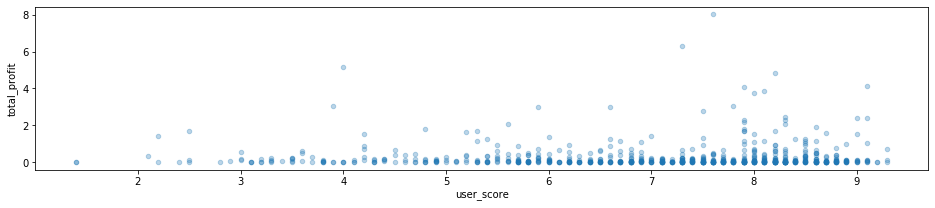

In [39]:
PC_platform.plot(x='user_score', y='total_profit', kind='scatter', alpha=0.3, figsize=(16, 3))
plt.show()

Таким орбразом, наиболее ярковыраженная корредяция между прибыль и рейтингами игр на платформе PS3, отсутсвует корреляция на PC. <br> **У нашего фафорита PS4 - нулевая корреляция с рейтингом игроков, положительная ярковыраженная корреляция с рейтингом критиков 4 к 10.**

<a name="6"></a>

<h2>Какие жанры самые прибыльные</h2>

Посмотрим на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?

Проанализируем жанры за актуальный период с 2013 года.

In [40]:
df = df.query('year_of_release > 2012')
genre_profit = df.groupby(['genre'])['total_profit'].sum()
genre_profit = pd.DataFrame(genre_profit)
genre_profit = genre_profit.sort_values(by='total_profit', ascending=False).reset_index()
genre_profit

,genre,total_profit
0,Action,322.50
1,Shooter,232.99
2,Sports,150.86
3,Role-Playing,145.89
4,Misc,62.82
5,Platform,42.63
6,Racing,40.21
7,Fighting,35.31
8,Adventure,23.64
9,Simulation,21.76


Наиболее прибыльными жанрами являются Action, Shooter, Sports, а наименее прибыльными - Strategy, Strategy, Puzzle. 

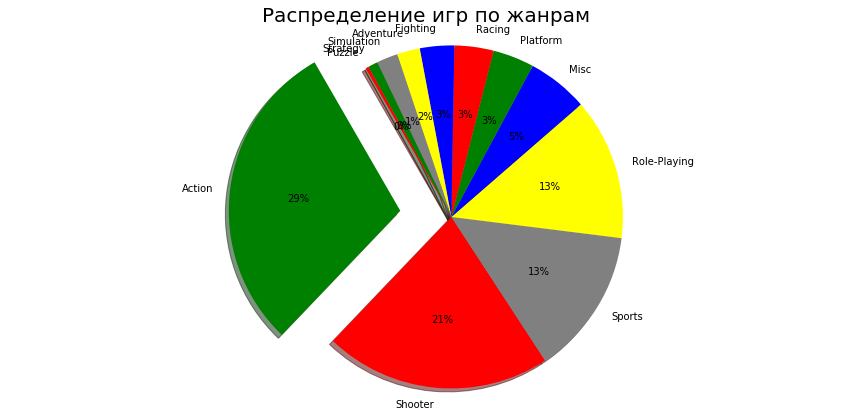

In [41]:
labels = genre_profit.genre
values = genre_profit.total_profit
colors = ['green','red','gray', 'yellow', 'blue', 'green','red','blue', 'yellow', 'gray', 'green','red','blue']
explode = [0.3,0,0,0,0,0,0,0,0,0,0,0]
plt.title('Распределение игр по жанрам', fontsize=20)
plt.pie(values,labels=labels,colors=colors,explode=explode,shadow=True,autopct='%1d%%',startangle=120)
plt.axis('equal')
plt.show()

На диаграме мы видим, что половину всех предпочтений игроков приходится всего на два жанра: Action предпочитают 29% игроков, Shooter - 21%.

<a name="7"></a>

<h2>Портрет пользователя каждого региона</h2>

<a name="8"></a>

Определим портрет для пользователя каждого региона (NA, EU, JP) **самые популярные платформы (топ-5) с 2013 года.** Опишем различия в долях продаж.

<h3>Портрет игрока из стран Северной Америки</h3>

In [42]:
na_platform = df.groupby(['platform'])['na_sales'].sum()
na_platform = pd.DataFrame(na_platform)
na_platform = na_platform.sort_values(by='na_sales', ascending=False).reset_index().head(5)
na_platform

,platform,na_sales
0,PS4,108.74
1,XOne,93.12
2,X360,81.67
3,PS3,63.50
4,3DS,38.20


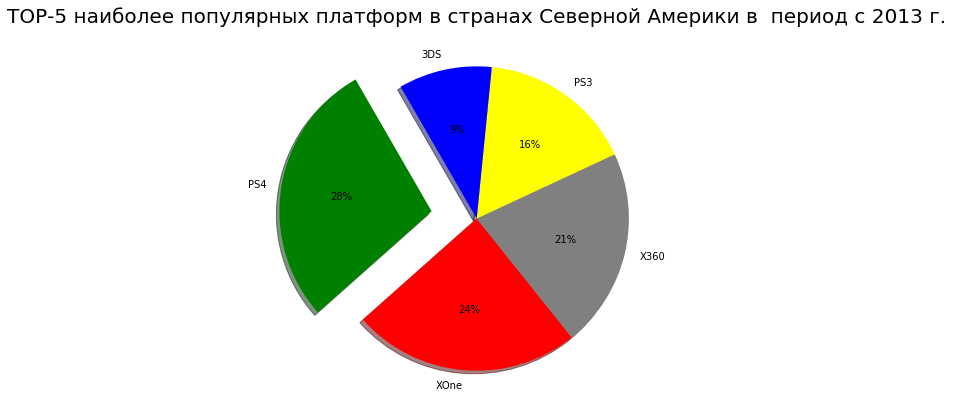

In [43]:
labels = na_platform.platform
values = na_platform.na_sales
colors = ['green','red','gray', 'yellow', 'blue']
explode = [0.3,0,0,0,0]
plt.title('TOP-5 наиболее популярных платформ в странах Северной Америки в  период с 2013 г.', fontsize=20)
plt.pie(values,labels=labels,colors=colors,explode=explode,shadow=True,autopct='%1d%%',startangle=120)
plt.show()

В США и Канаде наиболее популярной игровой платформой за актуальный период исследования является PS4.

In [44]:
genre_profit = df.groupby(['genre'])['na_sales'].sum()
genre_profit = pd.DataFrame(genre_profit)
genre_profit = genre_profit.sort_values(by='na_sales', ascending=False).reset_index().head(5)
genre_profit

,genre,na_sales
0,Action,126.13
1,Shooter,109.75
2,Sports,65.27
3,Role-Playing,46.40
4,Misc,27.49


Посмотрим какие жанры популярны в Америке и Канаде.

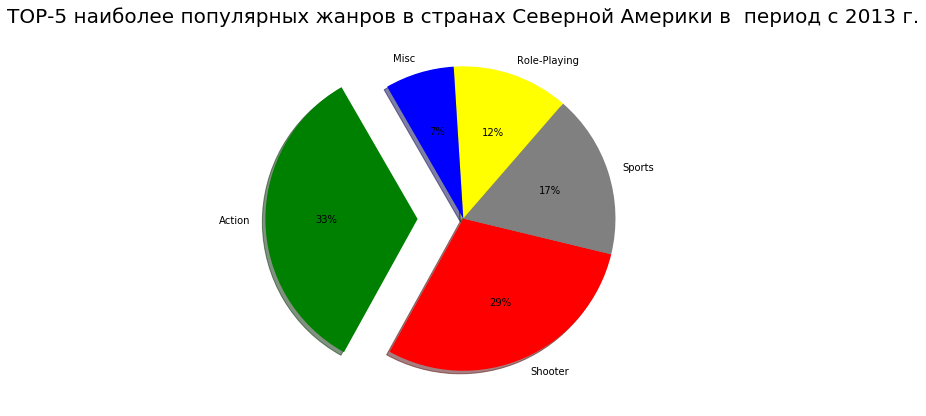

In [45]:
labels = genre_profit.genre
values = genre_profit.na_sales
colors = ['green','red','gray', 'yellow', 'blue']
explode = [0.3,0,0,0,0]
plt.title('TOP-5 наиболее популярных жанров в странах Северной Америки в  период с 2013 г.', fontsize=20)
plt.pie(values,labels=labels,colors=colors,explode=explode,shadow=True,autopct='%1d%%',startangle=120)
plt.show()

Наиболее популярный жанр в странах Северной Америки - Action.

In [46]:
age_profit = df.groupby(['age'])['na_sales'].sum()
age_profit = pd.DataFrame(age_profit)
age_profit = age_profit.sort_values(by='na_sales', ascending=False).reset_index().head(5)
age_profit

,age,na_sales
0,M,165.30
1,no age,89.42
2,E,79.05
3,E10+,54.24
4,T,49.79


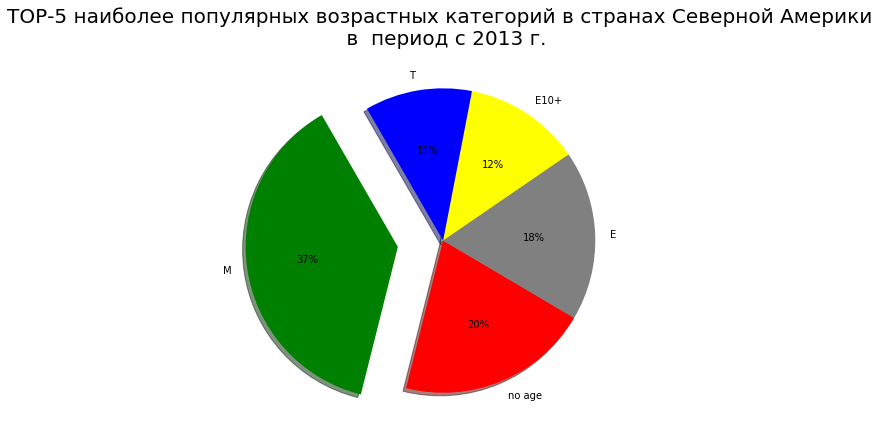

In [47]:
labels = age_profit.age
values = age_profit.na_sales
colors = ['green','red','gray', 'yellow', 'blue']
explode = [0.3,0,0,0,0]
plt.title('TOP-5 наиболее популярных возрастных категорий в странах Северной Америки \n в  период с 2013 г.', fontsize=20)
plt.pie(values,labels=labels,colors=colors,explode=explode,shadow=True,autopct='%1d%%',startangle=120)
plt.show()

Наиболее продаваемые из возрастной категории M - (mature - Материалы игры не подходят для подростков младше 17 лет). Проекты с данным рейтингом могут содержать достаточно жестокое насилие, большое количество крови с расчленением, непристойные сексуальные сцены или грубую ненормативную лексику, нежелательную для младшей аудитории.

**Портрет игрока из стран Северной Америки**: игроки из США и Канады предпочитают игры на платформе PS4, жанра Action с возрастным ограничением от 17 лет, которые могут содержать достаточно большое количество жестого насилия.

<a name="7"></a>

<h3>Портрет игрока из стран Евросоюза</h3>

In [48]:
eu_platform = df.groupby(['platform'])['eu_sales'].sum()
eu_platform = pd.DataFrame(eu_platform)
eu_platform = eu_platform.sort_values(by='eu_sales', ascending=False).reset_index().head(5)
eu_platform

,platform,eu_sales
0,PS4,141.09
1,PS3,68.11
2,XOne,51.59
3,X360,42.62
4,3DS,30.96


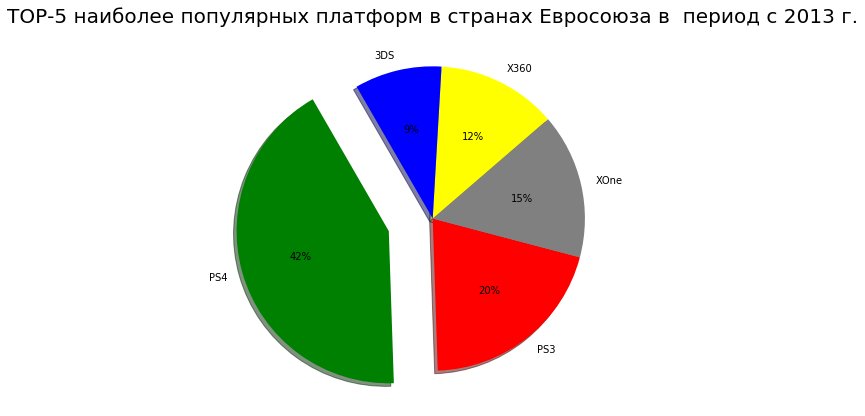

In [49]:
labels = eu_platform.platform
values = eu_platform.eu_sales
colors = ['green','red','gray', 'yellow', 'blue']
explode = [0.3,0,0,0,0]
plt.title('TOP-5 наиболее популярных платформ в странах Евросоюза в  период с 2013 г.', fontsize=20)
plt.pie(values,labels=labels,colors=colors,explode=explode,shadow=True,autopct='%1d%%',startangle=120)
plt.show()

В странах Евросоюза картина практически идентична: наиболее популярной игровой платформой является PS4.

Посмотрим какие жанры популярны в странах Европы.

In [50]:
genre_profit = df.groupby(['genre'])['eu_sales'].sum()
genre_profit = pd.DataFrame(genre_profit)
genre_profit = genre_profit.sort_values(by='eu_sales', ascending=False).reset_index().head(5)
genre_profit

,genre,eu_sales
0,Action,118.61
1,Shooter,87.86
2,Sports,60.68
3,Role-Playing,36.97
4,Racing,20.44


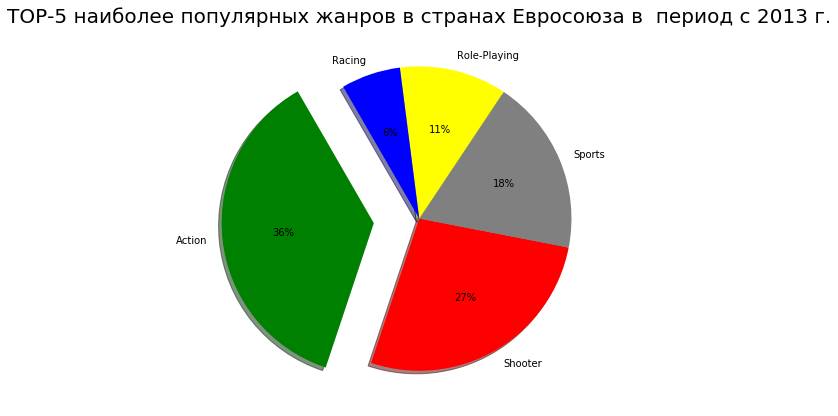

In [51]:
labels = genre_profit.genre
values = genre_profit.eu_sales
colors = ['green','red','gray', 'yellow', 'blue']
explode = [0.3,0,0,0,0]
plt.title('TOP-5 наиболее популярных жанров в странах Евросоюза в  период с 2013 г.', fontsize=20)
plt.pie(values,labels=labels,colors=colors,explode=explode,shadow=True,autopct='%1d%%',startangle=120)
plt.show()

Интересы в Европе схожи с американскими: популярны Action, Shooter, Sports.

In [52]:
age_profit = df.groupby(['age'])['eu_sales'].sum()
age_profit = pd.DataFrame(age_profit)
age_profit = age_profit.sort_values(by='eu_sales', ascending=False).reset_index().head(5)
age_profit

,age,eu_sales
0,M,145.80
1,E,83.36
2,no age,79.21
3,E10+,42.80
4,T,41.95


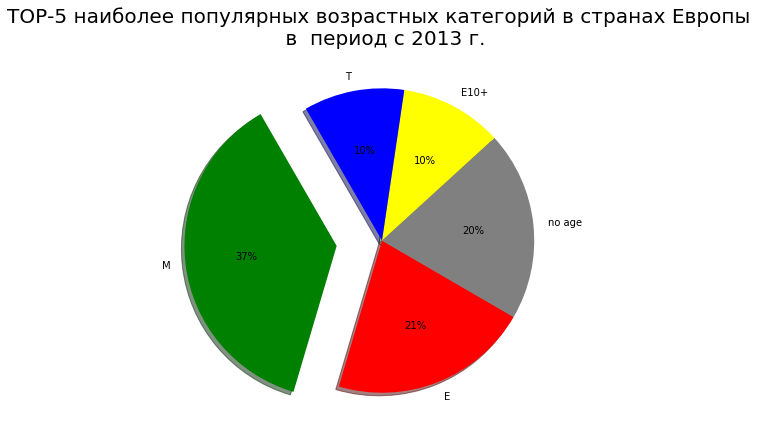

In [53]:
labels = age_profit.age
values = age_profit.eu_sales
colors = ['green','red','gray', 'yellow', 'blue']
explode = [0.3,0,0,0,0]
plt.title('TOP-5 наиболее популярных возрастных категорий в странах Европы \n в  период с 2013 г.', fontsize=20)
plt.pie(values,labels=labels,colors=colors,explode=explode,shadow=True,autopct='%1d%%',startangle=120)
plt.show()

Наиболее продаваемые из возрастной категории M - (mature - Материалы игры не подходят для подростков младше 17 лет). Проекты с данным рейтингом могут содержать достаточно жестокое насилие, большое количество крови с расчленением, непристойные сексуальные сцены или грубую ненормативную лексику, нежелательную для младшей аудитории.

**Портрет игрока из стран Европы** идентичен портрету из Америки: в Европе предпочитают игры на платформе PS4, жанра Action с возрастным ограничением от 17 лет, которые могут содержать достаточно большое количество жестого насилия.

<h3>Портрет игрока из Японии</h3>

In [54]:
jp_platform = df.groupby(['platform'])['jp_sales'].sum()
jp_platform = pd.DataFrame(jp_platform)
jp_platform = jp_platform.sort_values(by='jp_sales', ascending=False).reset_index().head(5)
jp_platform

,platform,jp_sales
0,3DS,67.81
1,PS3,23.36
2,PSV,18.59
3,PS4,15.96
4,WiiU,10.88


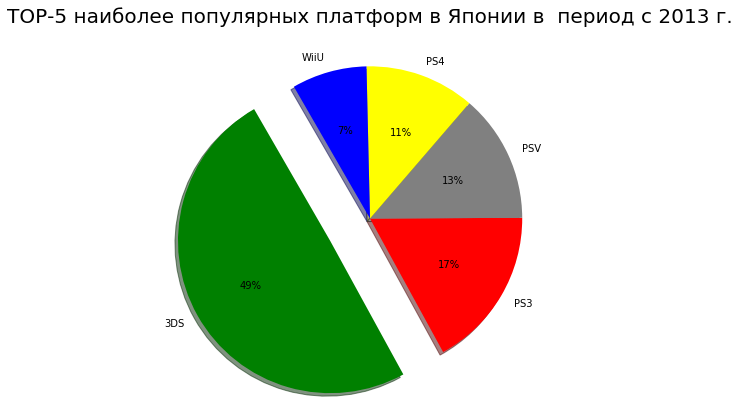

In [55]:
labels = jp_platform.platform
values = jp_platform.jp_sales
colors = ['green','red','gray', 'yellow', 'blue']
explode = [0.3,0,0,0,0]
plt.title('TOP-5 наиболее популярных платформ в Японии в  период с 2013 г.', fontsize=20)
plt.pie(values,labels=labels,colors=colors,explode=explode,shadow=True,autopct='%1d%%',startangle=120)
plt.show()

В Японии лидером среди игроков является 3DS.

In [56]:
genre_profit = df.groupby(['genre'])['jp_sales'].sum()
genre_profit = pd.DataFrame(genre_profit)
genre_profit = genre_profit.sort_values(by='jp_sales', ascending=False).reset_index().head(5)
genre_profit

,genre,jp_sales
0,Role-Playing,51.04
1,Action,40.49
2,Misc,9.20
3,Fighting,7.65
4,Shooter,6.61


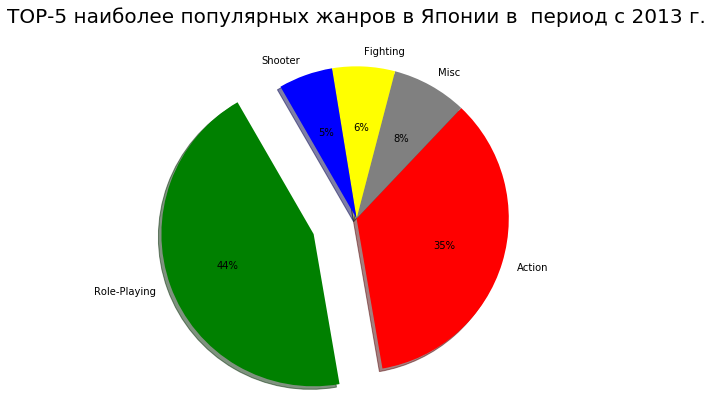

In [57]:
labels = genre_profit.genre
values = genre_profit.jp_sales
colors = ['green','red','gray', 'yellow', 'blue']
explode = [0.3,0,0,0,0]
plt.title('TOP-5 наиболее популярных жанров в Японии в  период с 2013 г.', fontsize=20)
plt.pie(values,labels=labels,colors=colors,explode=explode,shadow=True,autopct='%1d%%',startangle=120)
plt.show()

В Японии, в отличие от Европы и Америки, наиболее популярный жанр Role-Playing (традиционные настольные игры), вероятно потому что, Япония является родиной многих настольных интеллектуальных игр, и там сильны традиции и другая культура.

In [58]:
age_profit = df.groupby(['age'])['jp_sales'].sum()
age_profit = pd.DataFrame(age_profit)
age_profit = age_profit.sort_values(by='jp_sales', ascending=False).reset_index().head(5)
age_profit

,age,jp_sales
0,no age,85.06
1,T,20.59
2,E,15.14
3,M,14.11
4,E10+,5.89


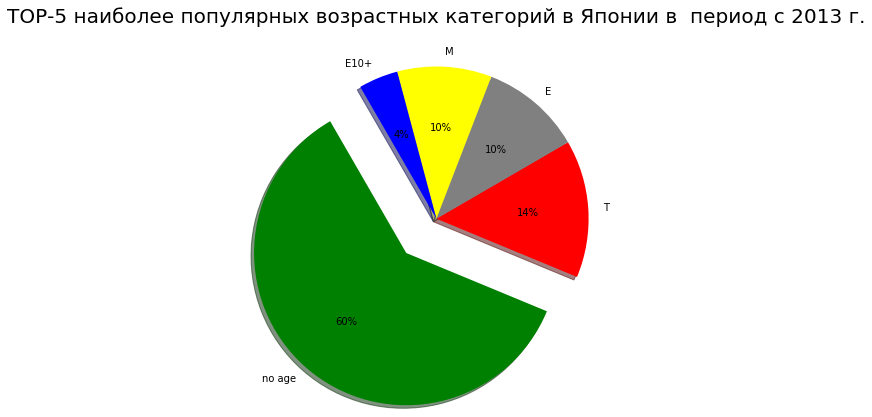

In [59]:
labels = age_profit.age
values = age_profit.jp_sales
colors = ['green','red','gray', 'yellow', 'blue']
explode = [0.3,0,0,0,0]
plt.title('TOP-5 наиболее популярных возрастных категорий в Японии в  период с 2013 г.', fontsize=20)
plt.pie(values,labels=labels,colors=colors,explode=explode,shadow=True,autopct='%1d%%',startangle=120)
plt.show()

Для большинства игр, предпочитаемых в Японии, возрастная категория не была определена, к сожалению. Следующая возрастная категория для которй имеются данные - Т («Teen») — «Подросткам»: Игра подходит для лиц от 13 лет и старше. Проекты из данной категории могут содержать насилие, непристойные сцены, грубый юмор, в меру откровенное сексуальное содержимое, кровь или нечастое использование ненормативной лексики.

**Портрет игрока из Японии:** в Японии предпочитают игры на местной игровой платформе 3DS, жанр настольных игр Role-Playing, возрастной категории T - которые подойдут подросткам от 13 лет.  

<a name="11"></a>

<h2>Проверка гипотез</h2>


Проверим две гипотезы. Первая нулевая гипотеза: **средние пользовательские рейтинги платформ Xbox One и PC одинаковые:**

Для того чтобы подтвердить или опровергнуть гипотезу статистическими методами программным способом: суммируем пользовтаельский рейтинг для каждой игровой платформы на основе отдельной таблицы, затем разделим полученное число на на длину этой таблицы за вычетом позиций nan в столбце пользовательского рейтинга. **Для проверки используем t-критерий Стьюдента потому что выборки являются независимыми, корреляции отсутсвуют.**

Значение alpha выбрано 0.05  потому что это общепринятое значение, всегда везде берут 0.05.

In [60]:
xone = df.query('platform == "XOne"')
xone = xone.query('year_of_release > 2012')
xone = xone['user_score'].dropna() # надо удалить строки которые равны нулю

pc = df.query('platform == "PC"')
pc = pc.query('year_of_release > 2012')
pc = pc['user_score'].dropna()

alpha = 0.05 # Значение alpha выбрано 0.05 потому что это общепринятое значение, всегда везде берут 0.05.

results = st.ttest_ind(pc, xone)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу, т.е. значения не равны, превышен критический порог 0,05")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.16588499016395244
Не получилось отвергнуть нулевую гипотезу


Если нулевую гипотезу равенства не удалось отвергнуть, то значит пользовательские рейтинги игры XOne и PC весьма схожи.

Вторая альтернативная гипотеза: **средние пользовательские рейтинги жанров Action и Sports разные.**

In [61]:
action = df[df['genre'] == 'Action']
action_series = action['user_score'].dropna()
# среднее значение рейтинга жанра Action = 6.91

# высчитаем средний пользовательский рейтинг для Sports таким же образом
sports = df[df['genre'] == 'Sports']
sports_series = sports['user_score'].dropna()
# среднее значение рейтинга жанра Sports = 6.84

alpha = 0.05

results = st.ttest_ind(action_series, sports_series)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу, т.е. значения не равны, превышен критический порог 0,05")
else:
    print("Не получилось отвергнуть нулевую гипотезу")
    

p-значение:  3.1178438718906782e-28
Отвергаем нулевую гипотезу, т.е. значения не равны, превышен критический порог 0,05


Значения рейтингов Action и Sports не равны.

<a name="12"></a>

<h1>Общий вывод</h1>

В ходе исследования мы произвели предобработку данных, заменили пропуски по необходимости, в большинстве случаев оставили пропуски как есть. Номрализовали таблицу по наименованиям столбцов. Проанализировали ситуцию в игровой индустрии в перспективе.

В ходе исследования мы выяснили, что устойчивой тенденции к росту прибыли до 1994 года не наблюдалось. **Рейтинги игроков стабильно начали учитывать с 1996 года**, до этого, оценки мнений игроков и исследователей не систематизировались. **Бурное развитие игровой индустрии наблюдается с 1994 по 2007 год**, после чего идет умеренный спад. **С 2007 по 2009 года в течение трех лет наблюдается перенасыщение рынка**, однако возникший мировой кризис 2008 года поспособствует снижению выручки, и **при сохраняющихся темпах производства новых игр, 2008 и 2009 год будут приносить меньше прибыли**, что затем вызовет  постепенное снижение объемов выпуска новых игр вплоть до 2010 года. 2010 год ознаменован распространением смартфонов, что также заберет часть рынка игр на себя. **После совокупности данных событий, объемы производства игр сохранятся на уровне 2012 года при продолжении снижения выручки, что говорит о продолжающимся перенасыщении рынка**, либо о предпочтении игроков к более старым форматам игр, либо отсутсвию оригинальных идей у разработчиков, либо отсутствие учета предпочтений игроков при разработке, либо успехом такой новинки как смартфон.

Таким образом **период с 1994 года по 2008 год можно считать самым успешным** в производстве игр, а **с 2012 года формируется новый рынок** с усточивым объемом производства игр.

Средний возраст жизни игровой платформы 5-10 лет. С наступлением нового периода в развитии игровых платформ, многие прекратили свое существование, и лидером рынка осталась игровая платформа PS4, в Японии - 3DS.

    В ходе проведенного анализа, мы определеили факторы, определяющие успешность игры на рынке. Пользовательские рейтинги игры XOne и PC весьма схожи. Но, если не учитывать игры для компьютера, наиболее популярной игровой платформой на данный момент осталась платформа PS4. Наиболее популярным игрой в Америке и Европе оказалась игра средней возрастной категории M от 17 лет жанров Action, Shooter и Sports. В Японии попуялрна платфорам 3DS. В Японии популярен жанр настольных игр Role-Playing возрастной категории T - для подростков от 13 лет.
    Если планировать рекламную кампанию, то следует учитывать популярность игровой платвормы в регионе.